In [17]:
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.gridspec as gridspec

In [18]:
# Constants
G = 6.67e-11 # Gravitational Constant (m^3/(kg*s^2))
C = 299_792_458 # Speed of Light (m/s)
AU = 1.5e11 # Astronomical Unit (m)
DAY_SECONDS = 24*60*60 # 1 day in seconds

SUN_RADIUS = 695_700_000 # Radius of the sun (m)
EARTH_RADIUS = 6.378e6
MARS_RADIUS = 3.3895e6

# Globals
t: float = 0
# Simulate 2 times a day
dt: float = DAY_SECONDS / 2
# Simulate 100 years
t_end = 100 * 365 * DAY_SECONDS

<IPython.core.display.Javascript object>


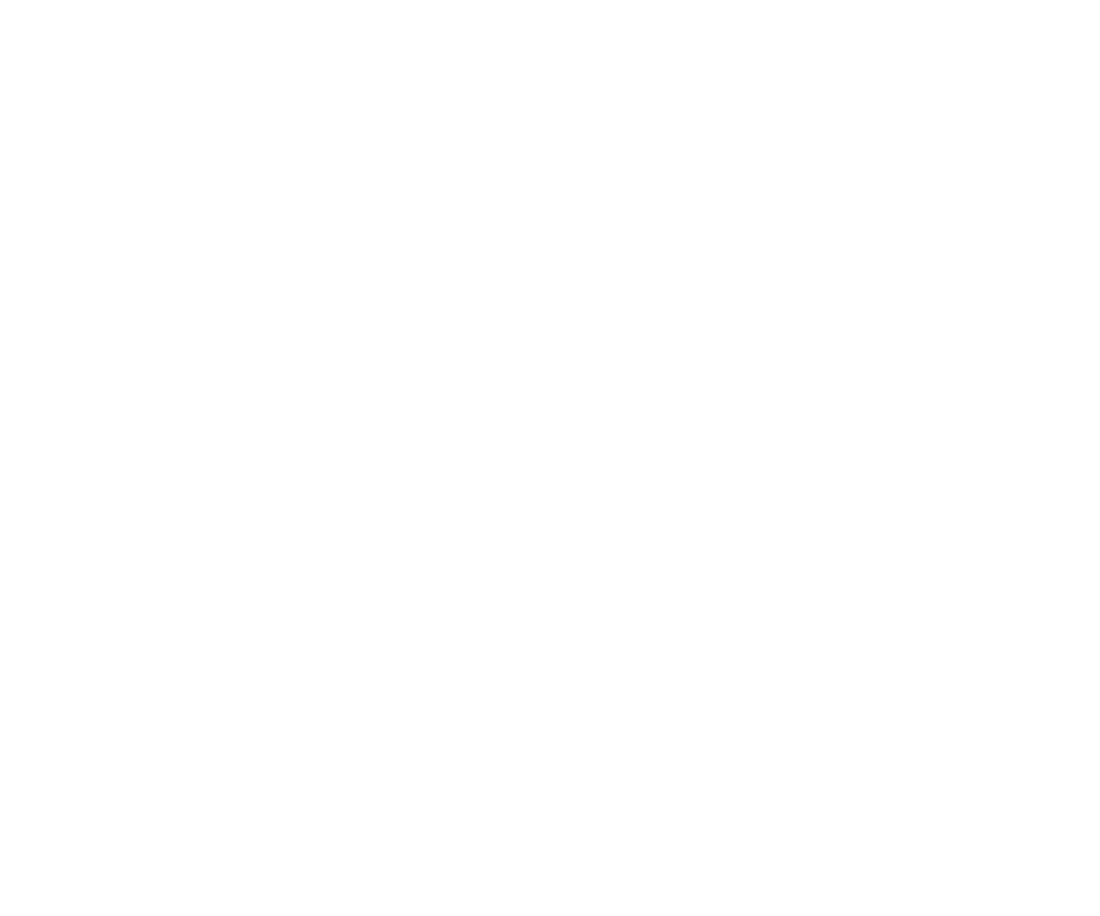

In [19]:
fig = plt.figure()
fig.set_size_inches(11, 110/12)

gs = gridspec.GridSpec(2, 2, height_ratios=[3,1])
gs.update(wspace=0.5)

sim_axis = fig.add_subplot(gs[0, 0:])
dist_ax = fig.add_subplot(gs[1, 0])
time_ax = fig.add_subplot(gs[1, 1])
fig.suptitle("Solar System Simulation")
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), height_ratios=[3, 1])

sim_axis.set_aspect('equal')
sim_axis.grid()
sim_axis.set_facecolor('gray')
sim_axis.axis('equal')
sim_axis.set_xlim(-4 * AU, 4 * AU)
sim_axis.set_ylim(-2 * AU, 2 * AU)
sim_axis.set_xlabel("Distance (m)")
sim_axis.set_ylabel("Distance (m)")

dist_ax.grid()
dist_ax.set_xlabel("Day")
dist_ax.set_ylabel("Distance between Earth and Mars (m)")
time_ax.grid()
time_ax.set_xlabel("Day")
time_ax.set_ylabel("Time to communicate (min)")

fig.set_facecolor('gray')

In [20]:
def distance(x1: float, y1: float, x2: float, y2: float) -> float:
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

In [21]:
class Body:
    # List of all celestial bodies
    BodyList: list['Body'] = []

    def __init__(self, name: str, mass: float, radius: float,
                x0: float=0, y0: float=0,
                vx0: float=0, vy0: float=0,
                color: str="blue", linewidth: float=1, 
                markersize: float=4) -> 'Body':
        self.name = name
        self.mass: float = mass

        self.x: float = x0
        self.y: float = y0

        self.xpositions: list[float] = [x0]
        self.ypositions: list[float] = [y0]

        self.xvelocities: list[float] = [vx0]
        self.yvelocities: list[float] = [vy0]

        self.vx: float = vx0
        self.vy: float = vy0

        self.line, = sim_axis.plot([], [], lw=linewidth, c=color)

        self.point, = sim_axis.plot([x0], [y0], marker="o", markersize=markersize, markeredgecolor=color, markerfacecolor=color)
        # self.point = plt.Circle((x0, y0), radius, color=color)
        self.text: plt.text = sim_axis.text(x0, y0, name)

        # Add to the list of celestial bodies
        Body.BodyList.append(self)

        # Gravity constants compared to all of the other bodies
        self.gravityDict: dict(str, float) = {}

    def update_pos(self) -> None:
        """
        Update the position and velocity of the body.
        
        F = G(m_1)(m_2)/d^2
        https://towardsdatascience.com/simulate-a-tiny-solar-system-with-python-fbbb68d8207b
        """
        for body in Body.BodyList:
            if (self == body):
                continue
            
            if (body.name not in self.gravityDict):
                self.gravityDict[body.name] = G * body.mass * self.mass 
            
            gravity_constant = self.gravityDict[body.name]

            x_dist = self.x - body.x
            y_dist = self.y - body.y

            # |sqrt(x^2 + y^2)|^3 = (x^2 + y^2)^1.5
            r3: float = ((x_dist)**2 + (y_dist)**2)**1.5

            fx = -gravity_constant*x_dist/r3
            fy = -gravity_constant*y_dist/r3

            self.vx += fx * dt / self.mass
            self.vy += fy * dt / self.mass
            
        self.x += self.vx * dt
        self.y += self.vy * dt

        self.xpositions.append(self.x)
        self.ypositions.append(self.y)
        self.xvelocities.append(self.vx)
        self.yvelocities.append(self.vy)
        pass

    def __eq__(self, other):
        if (isinstance(other, Body)):
            return self.name == other.name
        return False

In [22]:
times = []

def simulate():
    global times
    global t
    # 5 years of time (in seconds)
    while t < t_end:
        for body in Body.BodyList:
            body.update_pos()
        times.append(t)
        t += dt


# Runner code

sun = Body("The Sun", 2.0e30, SUN_RADIUS, 0, 0, 0, 0, "yellow", 1, 7)
earth = Body("Earth", 5.972e24, EARTH_RADIUS, 1.0167*AU, 0, 0, 29290, "blue", 1, 4)
mars = Body("Mars", 6.39e23, MARS_RADIUS, 1.666*AU, 0, 0, 21970, "red", 1, 4)

earth_mars_distance, = sim_axis.plot([], [], linestyle="--", color="green", linewidth=2)
earth_mars_text = sim_axis.text(0, 0, f"Distance: {0:.2f} AU")

sun_distance, = sim_axis.plot([], [], linestyle="--", color="orange", linewidth=1)

# mars_sun_distance, = sim_axis.plot([], [], linestyle="--")
# mars_sun_text = sim_axis.text(0, 0, f"Distance: {0:.2f} AU")

# mars_vector = sim_axis.plot([], [], linestyle="->")
mars_vector = sim_axis.arrow(0, 0, 0, 0, head_width=10e9, shape='full', head_starts_at_zero=False, animated=True)
mars_force_text = sim_axis.text(0, 0, f"Magnitude: {0:.2f}N")

earth_vector = sim_axis.arrow(0, 0, 0, 0, head_width=10e9, shape='full', head_starts_at_zero=False, animated=True)
earth_force_text = sim_axis.text(0, 0, f"Magnitude: {0:.2f}N")

distance_graph, = dist_ax.plot([], [], linestyle="-", color="blue", linewidth=1)
time_graph, = time_ax.plot([], [], linestyle="-", color="green", linewidth=1)

def get_mars_earth_distance(i):
    return ((mars.xpositions[i] - earth.xpositions[i])**2 + (mars.ypositions[i] - earth.ypositions[i])**2)**0.5

def get_mars_sun_distance(i):
    return ((mars.xpositions[i] - sun.xpositions[i])**2 + (mars.ypositions[i] - sun.ypositions[i])**2)**0.5

In [23]:
def update_animation(i):
    output_list = []

    earth_x = earth.xpositions[i]
    earth_y = earth.ypositions[i]
    mars_x = mars.xpositions[i]
    mars_y = mars.ypositions[i]
    sun_x = sun.xpositions[i]
    sun_y = sun.ypositions[i]

    curr_earth_mars_distance = earth_mars_distances[i]
    
    # https://stackoverflow.com/a/1079478

    earth_sun_x, earth_sun_y = (sun_x - earth_x, sun_y - earth_y)
    earth_mars_x, earth_mars_y = (mars_x - earth_x, mars_y - earth_y)

    # u * v / |v|**2
    k = (earth_sun_x*earth_mars_x + earth_sun_y*earth_mars_y)/(earth_mars_x**2 + earth_mars_y**2)

    # P_u(v) = v(u * v) / |v|**2
    projection_x_length, projection_y_length = (earth_mars_x * k, earth_mars_y * k)

    scale = projection_x_length / earth_mars_x if abs(earth_mars_x) > abs(earth_mars_y) else projection_y_length / earth_mars_y

    distance_to_sun = 0

    if (scale < 0):
        distance_to_sun = 1e30 # Basically infinity, because it's impossible to intersect the sun
        sun_distance.set_data([earth_x, sun_x], [earth_y, sun_y])
    elif (scale >= 1):
        distance_to_sun = 1e30 # Basically infinity, because it's impossible to intersect the sun
        sun_distance.set_data([mars_x, sun_x], [mars_y, sun_y])
    else:
        projection_x = earth_x + projection_x_length
        projection_y = earth_y + projection_y_length
        distance_to_sun = ((projection_x - sun_x)**2 + (projection_y - sun_y)**2)**0.5
        sun_distance.set_data([projection_x_length + earth_x, sun_x], [projection_y_length + earth_y, sun_y])
    
    is_conjunction = distance_to_sun < SUN_RADIUS + 2*EARTH_RADIUS

    output_list.append(sun_distance)

    if (not is_conjunction):
        earth_mars_distance.set(color='green', linestyle='--', linewidth=2)
        earth_mars_text.set_text(
            f"Distance:{(curr_earth_mars_distance / AU):.2f} AU\nTime to transmit:{((curr_earth_mars_distance / C)/60):.0f} minutes"
        )
    else:
        earth_mars_times[i] = 1e10 # basically infinity
        earth_mars_distance.set(color='red', linestyle='dotted', linewidth=1)
        earth_mars_text.set_text(
            f"Distance:{(curr_earth_mars_distance / AU):.2f} AU\nTime to transmit: infinite (solar conjunction)"
        )

    earth_mars_distance.set_data([earth_x, mars_x], [earth_y, mars_y])
    output_list.append(earth_mars_distance)

    # mars_sun_distance.set_data([mars_x, sun_x], [mars_y, sun_y])
    # output_list.append(mars_sun_distance)

    earth_mars_text_x = (2*earth_x + mars_x)/3
    earth_mars_text_y = (2*earth_y + mars_y)/3

    # mars_sun_text_x = (2*mars_x + sun_x)/3
    # mars_sun_text_y = (2*mars_y + sun_y)/3

    # curr_mars_sun_distance = mars_sun_distances[i]

    earth_mars_text.set_position((earth_mars_text_x, earth_mars_text_y))

    output_list.append(earth_mars_text)

    # mars_x_force = mars.xvelocities[i] * mars.mass / dt
    # mars_y_force = mars.yvelocities[i] * mars.mass / dt

    # mars_force_magnitude = (mars_x_force**2 + mars_y_force**2)**0.5
    mars_velocity_magnitude = (mars.xvelocities[i]**2 + mars.yvelocities[i]**2)**0.5

    mars_vector.set_data(x=mars_x, dx=mars.xvelocities[i]*2e6, y=mars_y, dy=mars.yvelocities[i]*2e6)
    # mars_force_text.set_text(f"{'%.2e' % mars_force_magnitude} N\n{mars_velocity_magnitude:.2f} m/s")
    mars_force_text.set_text(f"{mars_velocity_magnitude:.2f} m/s")
    mars_force_text.set_position((
        mars.xpositions[i] + mars.xvelocities[i]*3e6, 
        mars.ypositions[i] + mars.yvelocities[i]*2e6 - 3e10
    ))

    output_list.append(mars_vector)
    output_list.append(mars_force_text)

    # earth_x_force = earth.xvelocities[i] * earth.mass / dt
    # earth_y_force = earth.yvelocities[i] * earth.mass / dt

    # earth_force_magnitude = (earth_x_force**2 + earth_y_force**2)**0.5
    earth_velocity_magnitude = (earth.xvelocities[i]**2 + earth.yvelocities[i]**2)**0.5

    earth_vector.set_data(x=earth_x, dx=earth.xvelocities[i]*2e6, y=earth_y, dy=earth.yvelocities[i]*2e6)
    # earth_force_text.set_text(f"{'%.2e' % earth_force_magnitude} N\n{earth_velocity_magnitude:.2f} m/s")
    earth_force_text.set_text(f"{earth_velocity_magnitude:.2f} m/s")
    earth_force_text.set_position((
        earth.xpositions[i] + earth.xvelocities[i]*2e6, 
        earth.ypositions[i] + earth.yvelocities[i]*2e6 - 3e10
    ))

    output_list.append(earth_vector)
    output_list.append(earth_force_text)

    # mars_sun_text.set_text(
    #     f"Distance:{(curr_mars_sun_distance / AU):.2f} AU")
    
    # mars_sun_text.set_position((mars_sun_text_x, mars_sun_text_y))

    # output_list.append(mars_sun_text)

    for body in Body.BodyList:
        body.line.set_data(body.xpositions[0:i], body.ypositions[0:i])
        # body.point.set(center=(body.xpositions[i], body.ypositions[i]))
        # sim_axis.add_patch(body.point)
        body.point.set_data(body.xpositions[i], body.ypositions[i])
        body.text.set_position((body.xpositions[i], body.ypositions[i]))

        output_list.append(body.line)
        output_list.append(body.point)
        output_list.append(body.text)
    
    distance_graph.set_data(days[:i], earth_mars_distances_au[:i])
    time_graph.set_data(days[:i], earth_mars_times[:i])

    dist_ax.set_xlim(0, days[i] + 1)
    time_ax.set_xlim(0, days[i] + 1)

    output_list.append(distance_graph)
    output_list.append(time_graph)

    return output_list

In [25]:
%matplotlib notebook

simulate()

days = [time / DAY_SECONDS for time in times]

earth_mars_distances = [get_mars_earth_distance(i) for i in range(len(earth.xpositions))]
earth_mars_distances_au = [distance / AU for distance in earth_mars_distances]
earth_mars_times = [distance / C / 60 for distance in earth_mars_distances]
# mars_sun_distances = [get_mars_sun_distance(i) for i in range(len(mars.xpositions))]

dist_ax.set_ylim(min(earth_mars_distances_au) - 0.5, max(earth_mars_distances_au) + 0.5)
time_ax.set_ylim(0, 24)

anim = animation.FuncAnimation(
    fig,
    func=update_animation,
    frames=int(t_end / dt),
    interval=50,
    blit=False,
    repeat=False
)

plt.show()